# import library

In [30]:
import spacy
import en_core_web_sm
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from sklearn.linear_model import LogisticRegression
from statsmodels.miscmodels.ordinal_model import OrderedModel

import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import Counter

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# load data

In [20]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ColabNotebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ColabNotebooks


In [8]:
df = pd.read_csv("train.csv")
df.head()

,label,text
0,0,Batch #5\n\nAppearance: Pours a slightly hazy ...
1,0,Murky peach color with off-white head. Aroma h...
2,0,Can poured into a Spiegelau IPA glass\n\nA: Po...
3,0,A big thanks to Jeff for this one. 750ml cappe...
4,0,On tap into a shaker pint.\n\nAppearance is go...


# Doc2Vec

## data pre-processing

In [10]:
nlp = en_core_web_sm.load()

In [11]:
#### Define preprocess function
def preprocess(text):
    doc = nlp(text)
    return [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.is_alpha]

In [12]:
# tokenize
tkns_docs = [preprocess(text) for text in tqdm(df.text)]

100%|██████████| 21057/21057 [09:13<00:00, 38.07it/s]


In [32]:
# convert data into Doc2Vec required format
tgd_X = [TaggedDocument(d, [i]) for i, d in enumerate(tkns_docs)]

# train Doc2Vec model
model = Doc2Vec(
        tgd_X, vector_size=100, min_count=1, workers=4, epochs=100
    )

In [33]:
# get Doc2Vec vectors
vectors = [model.infer_vector(x) for x in tqdm(tkns_docs)]
vectors = [x.tolist() for x in vectors]
vectors[0]

100%|██████████| 21057/21057 [04:46<00:00, 73.57it/s]


array([-0.37231916,  1.0199081 ,  1.0140481 , -2.162124  ,  1.572941  ,
       -1.8727392 ,  2.0834837 ,  2.2997837 ,  0.31657675,  0.5467829 ,
        0.22980933, -0.5549749 ,  0.56626236,  1.6639483 ,  1.2912456 ,
       -0.90123504,  0.92377234, -1.124919  , -1.0149044 , -2.9617999 ,
       -1.507964  ,  0.20325506,  0.92702305, -0.07864133, -0.0763566 ,
        0.21011572, -0.14997311, -1.0564966 ,  1.2880863 ,  0.1657758 ,
       -1.0917772 , -2.1266026 ,  0.12136046,  3.7420497 , -1.337215  ,
       -0.7154637 , -1.3417315 ,  0.6122317 , -0.08191516, -1.5588884 ,
       -0.8100711 , -1.6017216 ,  0.5224127 , -0.59397036,  0.06969806,
        0.56980556, -1.6237268 , -0.8423298 , -0.3776801 , -0.14432867,
       -1.2861766 , -1.2260138 , -0.27994567,  0.52316374,  0.25850675,
       -1.1685823 ,  0.91008663,  1.24398   , -2.695781  , -0.260016  ,
        0.47648725, -1.111665  ,  0.11563493,  1.4016554 ,  0.77051425,
       -0.4567975 ,  1.7877027 , -0.58864725, -0.6963514 , -2.41

In [ ]:
# train-test split
train_X, test_X, train_Y, test_Y = train_test_split(vectors, df.label, test_size=0.6,random_state = 123)

## Model 1: multinomial logistics regression

In [13]:
# train multinomial logistics regression
lr = LogisticRegression(random_state=123, multi_class='multinomial')
lr.fit(train_X, train_Y)

LogisticRegression(multi_class='multinomial', random_state=123)

In [14]:
# predict labels for test set
pred_Y_lr = lr.predict(test_X)

In [16]:
# check accuracy and f1 score
print("Accuracy:", accuracy_score(test_Y, pred_Y_lr))
print(classification_report(test_Y, pred_Y_lr))

Accuracy: 0.5733280569845667
              precision    recall  f1-score   support

           0       0.62      0.63      0.62      4260
           1       0.45      0.36      0.40      4211
           2       0.62      0.73      0.67      4164

    accuracy                           0.57     12635
   macro avg       0.56      0.57      0.56     12635
weighted avg       0.56      0.57      0.56     12635



## Model 2: logit ordinal regression

In [ ]:
# sort the data by the label
dfTrain = pd.DataFrame([[y]+x for x,y in zip(train_X,train_Y)],
                       columns=['label']+['d'+str(x) for x in np.arange(1,101)])
dfTrain.sort_values(by=['label'],inplace=True)
dfTrain.reset_index(drop=True, inplace=True)

dfTest = pd.DataFrame([[y]+x for x,y in zip(test_X,test_Y)],
                       columns=['label']+['d'+str(x) for x in np.arange(1,101)])
dfTest.sort_values(by=['label'],inplace=True)
dfTest.reset_index(drop=True, inplace=True)


dfTrain.to_csv('Doc2Vec-Train.csv')
dfTest.to_csv('Doc2Vec-Test.csv')

In [108]:
# train logit ordinal regression
ordReg = OrderedModel(dfTrain.label, dfTrain.drop('label', axis=1),
                      distr='logit')
ordReg = ordReg.fit(method='bfgs', disp=False)

In [109]:
# have a look in the coefficients
ordReg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                  label   Log-Likelihood:                -7495.5
Model:                   OrderedModel   AIC:                         1.520e+04
Method:            Maximum Likelihood   BIC:                         1.591e+04
Date:                Tue, 18 Jul 2023                                         
Time:                        22:53:17                                         
No. Observations:                8422                                         
Df Residuals:                    8320                                         
Df Model:                         102                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
d1             0.0890      0.019      4.574      0.000       0.051       0.127
d2            -0.1178      0.018     -6.409      0.000      -0.154      -0.082
d3             0.0211      0.019      1.090      0.276      -0.017       0.059
d4             0.1402      0.019      7.537      0.000       0.104       0.177
d5            -0.0612      0.019     -3.289      0.001      -0.098      -0.025
d6            -0.1110      0.019     -5.871      0.000      -0.148      -0.074
d7            -0.0638      0.020     -3.206      0.001      -0.103      -0.025
d8             0.0325      0.018      1.773      0.076      -0.003       0.068
d9            -0.1599      0.018     -8.801      0.000      -0.195      -0.124
d10           -0.0831      0.018     -4.742      0.000      -0.117      -0.049
d11           -0.1424      0.019     -7.566      0.000      -0.179      -0.106
d12            0.1103      0.019      5.866      0.000       0.073       0.147
d13           -0.0938      0.018     -5.238      0.000      -0.129      -0.059
d14            0.0088      0.018      0.503      0.615      -0.026       0.043
d15           -0.1118      0.018     -6.218      0.000      -0.147      -0.077
d16           -0.1357      0.019     -7.281      0.000      -0.172      -0.099
d17           -0.0581      0.019     -3.023      0.003      -0.096      -0.020
d18            0.0797      0.021      3.739      0.000       0.038       0.122
d19           -0.1878      0.019     -9.835      0.000      -0.225      -0.150
d20           -0.0702      0.019     -3.756      0.000      -0.107      -0.034
d21            0.0264      0.019      1.401      0.161      -0.011       0.063
d22           -0.0675      0.018     -3.694      0.000      -0.103      -0.032
d23           -0.0306      0.018     -1.715      0.086      -0.066       0.004
d24            0.1677      0.020      8.185      0.000       0.128       0.208
d25           -0.0373      0.018     -2.099      0.036      -0.072      -0.002
d26           -0.0175      0.019     -0.943      0.346      -0.054       0.019
d27           -0.0463      0.019     -2.411      0.016      -0.084      -0.009
d28            0.0138      0.019      0.730      0.465      -0.023       0.051
d29            0.0389      0.018      2.184      0.029       0.004       0.074
d30           -0.1521      0.018     -8.298      0.000      -0.188      -0.116
d31           -0.1409      0.019     -7.334      0.000      -0.179      -0.103
d32            0.0301      0.019      1.597      0.110      -0.007       0.067
d33           -0.1054      0.019     -5.502      0.000      -0.143      -0.068
d34            0.0166      0.017      0.967      0.333      -0.017       0.050
d35            0.0556      0.020      2.765      0.006       0.016       0.095
d36           -0.0847      0.019     -4.444      0.000      -0.122      -0.047
d37            0.1466      0.020      7.163      0.000       0.107       0.187
d3

In [110]:
# get predicted probabilities for test set
pred_prob = ordReg.predict(dfTest.drop('label', axis=1))
pred_prob = pred_prob.values.tolist()
pred_prob[:10]

[[0.43535165687522287, 0.4039246423985922, 0.16072370072618491],
 [0.4069279910900457, 0.41598695057984164, 0.17708505833011268],
 [0.8077199519025258, 0.15832473527064628, 0.033955312826827955],
 [0.036652554795094404, 0.16823393665621225, 0.7951135085486933],
 [0.4496014949320716, 0.3973153578714609, 0.15308314719646754],
 [0.6723785827320772, 0.2605058352680679, 0.0671155819998549],
 [0.9374050494318176, 0.052831839693608385, 0.009763110874574044],
 [0.4945889027140168, 0.3743098856228171, 0.13110121166316613],
 [0.6461551444613959, 0.27903733163954203, 0.07480752389906209],
 [0.7775142804064837, 0.18194804781233687, 0.040537671781179396],
 [0.9141042731028126, 0.07221123147987074, 0.013684495417316644],
 [0.39366861427426847, 0.42105270596384414, 0.1852786797618874],
 [0.6912080774288194, 0.24691161181555343, 0.061880310755627166],
 [0.3377416027764193, 0.4377401652321071, 0.22451823199147358],
 [0.28434716572048857, 0.4447215920742562, 0.2709312422052552],
 [0.34793216617795353, 0

In [111]:
# use the highest probaility class as the predicted class
pred_Y = np.array(pred_prob).argmax(1)
pred_Y[:10]

array([0, 1, 0, ..., 2, 2, 2])

In [112]:
# check accuracy and f1 score
print("Accuracy:", accuracy_score(dfTest.label, pred_Y))
print(classification_report(dfTest.label, pred_Y))

Accuracy: 0.5566284131381084
              precision    recall  f1-score   support

           0       0.62      0.60      0.61      4260
           1       0.41      0.40      0.40      4211
           2       0.63      0.68      0.66      4164

    accuracy                           0.56     12635
   macro avg       0.55      0.56      0.56     12635
weighted avg       0.55      0.56      0.55     12635



## Model 3. Simple Neural Network

In [21]:
dfTrain = pd.read_csv('Doc2Vec-Train.csv').drop(columns='Unnamed: 0')
dfTest = pd.read_csv('Doc2Vec-Test.csv').drop(columns='Unnamed: 0')

In [9]:
# set up hyper-parameter
n_neurons = 16
n_hidden = 3
learning_rate = 1e-3

In [36]:
keras.backend.clear_session()

# set up the normalization layer for later use
#norm_layer = keras.layers.BatchNormalization() # transform the data trying to achieve mean = 0, sd = 1

#============== model START =================

# Input layer
input = keras.layers.Input(shape=[100]) # layer for inputting data
#norm = norm_layer(input) # layer for normalizing data

# Hidden layers
for layer in range(n_hidden):
    if layer == 0:
        hidden = keras.layers.Dense(n_neurons, activation="relu")(input) # first hidden layer, with n_neurons neurons
    else:
        hidden = keras.layers.Dense(n_neurons, activation="relu")(hidden) # other hidden layers, with n_neurons neurons

# output layer
output = keras.layers.Dense(3, activation="softmax")(hidden)

#================ model END =====================

# Create the model
model0 = keras.Model(inputs=input, outputs=output)

# Specify the model
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model0.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])


# Train the model dfTest.label, pred_Y
history0 = model0.fit(dfTrain.drop('label', axis=1), dfTrain.label, epochs=20,
                     validation_data=(dfTest.drop('label', axis=1), dfTest.label))

# evaluate
eval0 = model0.evaluate(dfTest.drop('label', axis=1), dfTest.label)
print(eval0[1])

Epoch 1/20
264/264 [==============================] - 4s 9ms/step - loss: 1.1020 - accuracy: 0.3795 - val_loss: 1.0304 - val_accuracy: 0.4672
Epoch 2/20
264/264 [==============================] - 2s 6ms/step - loss: 0.9617 - accuracy: 0.5191 - val_loss: 0.9284 - val_accuracy: 0.5398
Epoch 3/20
264/264 [==============================] - 2s 6ms/step - loss: 0.8970 - accuracy: 0.5613 - val_loss: 0.9177 - val_accuracy: 0.5434
Epoch 4/20
264/264 [==============================] - 2s 6ms/step - loss: 0.8745 - accuracy: 0.5864 - val_loss: 0.9099 - val_accuracy: 0.5503
Epoch 5/20
264/264 [==============================] - 2s 8ms/step - loss: 0.8610 - accuracy: 0.5913 - val_loss: 0.9127 - val_accuracy: 0.5486
Epoch 6/20
264/264 [==============================] - 2s 7ms/step - loss: 0.8480 - accuracy: 0.6065 - val_loss: 0.9154 - val_accuracy: 0.5482
Epoch 7/20
264/264 [==============================] - 2s 9ms/step - loss: 0.8367 - accuracy: 0.6141 - val_loss: 0.9216 - val_accuracy: 0.5501
Epoch 

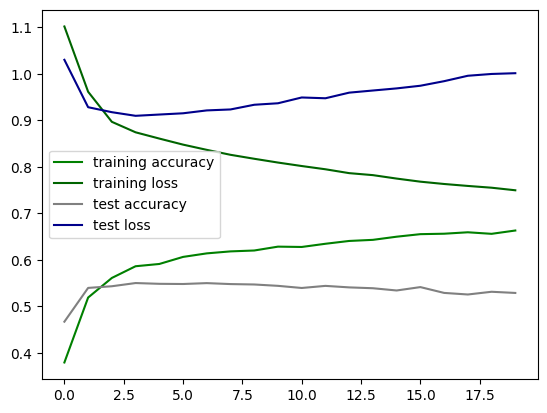

In [37]:
# plot loss and accuracy
def create_plot(log):
    plt.plot(log.history['accuracy'],label = "training accuracy",color='green')
    plt.plot(log.history['loss'],label = "training loss",color='darkgreen')
    plt.plot(log.history['val_accuracy'], label = "test accuracy",color='grey')
    plt.plot(log.history['val_loss'], label = "test loss",color='darkblue')
    plt.legend()
    plt.show()
create_plot(history0)

In [38]:
# calculate f1 score
y_prob = model0.predict(dfTest.drop('label', axis=1))
y_pred = np.argmax(y_prob.tolist(), axis=1)
f1_score(dfTest.label, y_pred, average='micro')

395/395 [==============================] - 2s 4ms/step


0.5290067273446775